Imports:

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import kagglehub
from kagglehub import KaggleDatasetAdapter

Found GPU at: /device:GPU:0


In [ ]:
#File is run in google colab so that tensorflow runs with a GPU

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 1: Loading and Processing Training Data

In [ ]:
#loading metadata from kagglehub
file_path = "HAM10000_metadata.csv"
metadata = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "kmader/skin-cancer-mnist-ham10000",
  file_path
)

#filepath for training images in personal google drive
data_dir = 'drive/MyDrive/HAM10000_images'

#converting to binary labels: 0 for benign, 1 for malignant
benign_labels = ['nv', 'bkl', 'df','vasc']
malignant_labels = ['mel', 'bcc', 'akiec']
metadata['binary_label'] = metadata['dx'].apply(lambda x: 0 if x in benign_labels else 1)
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(data_dir, f'{x}.jpg'))

#splitting into training and validation data
train_metadata, val_metadata = train_test_split(metadata, test_size=0.2, stratify=metadata['binary_label'], random_state=42)

#processing images (random rotation, brightness & contrast edits) + creating tensorflow datasets
def load_image(image_path, label, augment=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224,224))
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

def create_dataset(metadata, batch_size=32, augment=False):
    image_paths = metadata['image_path'].values
    labels = metadata['binary_label'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: load_image(x, y, augment), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

batch_size = 16
train_dataset = create_dataset(train_metadata, batch_size=batch_size, augment=True)
val_dataset = create_dataset(val_metadata, batch_size=batch_size, augment=False)

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.


Step 3: Training the model

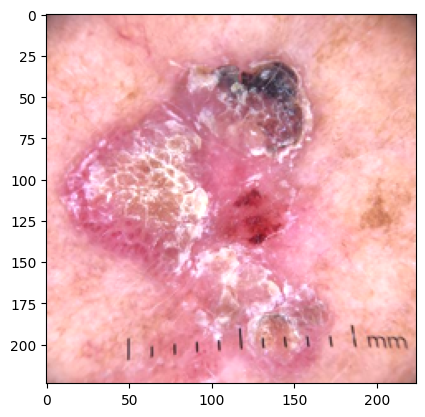

num fair = 105  num dark + vdark = 46  num vdark = 12


In [6]:
#creating extra validation sets to test racial bias using bosque dataset
bosque_data = np.load("drive/MyDrive/BOSQUE_data.npy", allow_pickle=True)
imgs = bosque_data[0]
labs = bosque_data[1]
skin = bosque_data[2]

img = imgs[0]
plt.figure()
plt.imshow(img)
plt.show()

#splitting into fair, dark, and especially dark skintones
fair_labels = labs[skin < 4]
fair_imgs = imgs[skin < 4]

dark_labels = labs[skin > 3]
dark_imgs = imgs[skin > 3]

vdark_labels = labs[skin > 4]
vdark_imgs = imgs[skin > 4]

print("num fair =",len(fair_labels)," num dark + vdark =",len(dark_labels)," num vdark =", len(vdark_labels))

fair_set, dark_set, vdark_set = np.empty(2, dtype=object),np.empty(2, dtype=object),np.empty(2, dtype=object)

fair_set[0],fair_set[1]=fair_imgs,fair_labels
dark_set[0],dark_set[1]=dark_imgs,dark_labels
vdark_set[0],vdark_set[1]=vdark_imgs,vdark_labels


In [ ]:
#loading resNet model with pre-trained weights
resNet_model =  tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False)

#adding additional layers
x = resNet_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=resNet_model.input, outputs=predictions)

#allowing the base model to be trained
for layer in resNet_model.layers[-200:]:
    layer.trainable = True

#compiling the model with given optimizer. Loss function is binary crossentropy
optim = tf.keras.optimizers.SGD(learning_rate=0.000005, momentum = 0.9, nesterov = True)
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

#creating a callback to track accuracy and loss of bosque test sets after every epoch
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets):
        self.val_sets = validation_sets
        self.num_val_sets = len(validation_sets)

    def on_train_begin(self, logs=None):
        self.val_results = [[] for _ in range(self.num_val_sets)]

    def on_epoch_end(self, batch, logs=None):

        for i in range(self.num_val_sets):
            set = self.val_sets[i]
            self.val_results[i].append(self.model.evaluate(x=set[0],
                                          y=set[1], verbose = 0))


val_sets = np.empty(3, dtype=object)
val_sets[0],val_sets[1],val_sets[2]=fair_set, dark_set,vdark_set

LH = LossHistory(val_sets)

#adjusting loss function so that mis-assigning malignant lesions is more heavily penalized
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(metadata['binary_label']), y=metadata['binary_label'])
class_weights = dict(enumerate(class_weights))


#training model, stopping training once val loss does not improve for 15 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(train_dataset, epochs=200,
                    validation_data=val_dataset,callbacks=[LH,early_stopping],class_weight=class_weights)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/200
 84/807 ━━━━━━━━━━━━━━━━━━━━ 7:26 618ms/step - accuracy: 0.5267 - loss: 1.6645

In [1]:
fair_loss = [pair[0] for pair in LH.val_results[0]]
dark_loss = [pair[0] for pair in LH.val_results[1]]
vdark_loss = [pair[0] for pair in LH.val_results[2]]
plt.plot(fair_loss, label='fair')
plt.plot(dark_loss, label='dark')
plt.plot(vdark_loss, label = 'very dark')
plt.plot(history.history['val_loss'], label = 'validation')
plt.plot(history.history['loss'], label = 'training')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,3])
plt.legend(loc='upper right')


NameError: name 'LH' is not defined

In [ ]:
model.save('drive/MyDrive/sgd5e-6.keras')

history_df = pd.DataFrame(history.history)
history_df.to_csv('drive/MyDrive/sgd5e-6.csv', index=False)